<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "Exc-HPF"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level2-MajorCellType/Exc-HPF/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


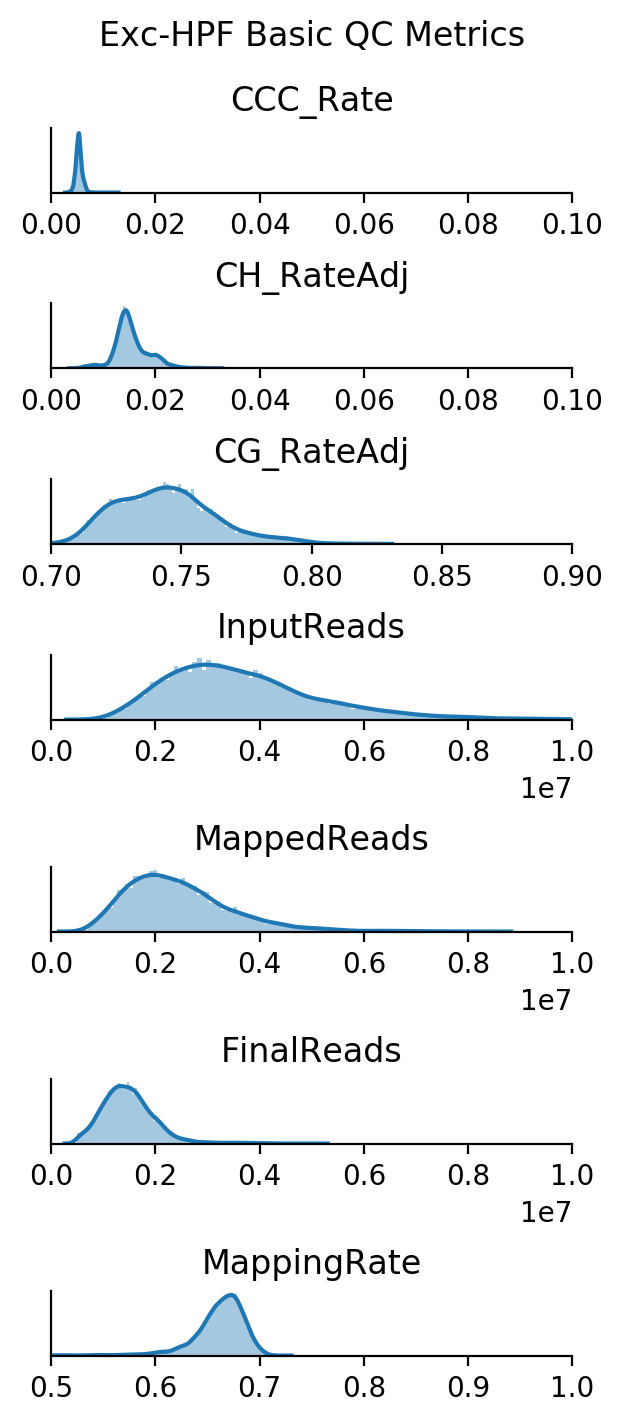

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

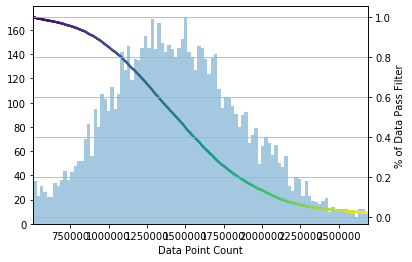

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 7908/7908 (100.0%)
CG_RateAdj passed 7908/7908 (100.0%)
CH_RateAdj passed 7908/7908 (100.0%)
FinalReads passed 7908/7908 (100.0%)
MappingRate passed 7908/7908 (100.0%)
Overall passed 7908/7908 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
180129 1
180130 2
180205 10
180206 10
180917 48
181204 23
190108 13
190117 18
190205 16
190212 980
190214 916
190219 1184
190305 790
190307 12
190625 413
190627 1027
190711 1253
190716 1192


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 968 252.1%
ad002 1025 266.9%
ad004 1006 262.0%
ad006 1015 264.3%
ad007 973 253.4%
ad008 968 252.1%
ad010 979 254.9%
ad012 974 253.6%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,MappingRate,Pos96,Plate,Col96,Row96,Col384,Row384,FACS_Date,Slice,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
10E_M_1,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.006019,0.743035,0.741479,0.024127,0.018218,2009998.0,5524084,3657352.0,10E,...,0.662074,A1,CEMBA190625-10E-1,0,0,0,1,190625,10,True
10E_M_10,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.006569,0.750172,0.748520,0.027665,0.021235,1383636.0,3455260,2172987.0,10E,...,0.628892,A10,CEMBA190625-10E-1,9,0,19,0,190625,10,True
10E_M_101,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.006353,0.760898,0.759369,0.026547,0.020323,2474670.0,7245482,4778768.0,10E,...,0.659551,B10,CEMBA190625-10E-1,9,1,18,3,190625,10,True
10E_M_102,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.005409,0.752980,0.751637,0.019497,0.014164,2430290.0,7004754,4609570.0,10E,...,0.658063,B10,CEMBA190625-10E-1,9,1,19,2,190625,10,True
10E_M_103,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.005817,0.734664,0.733111,0.021539,0.015813,2949180.0,8645474,5564327.0,10E,...,0.643612,B10,CEMBA190625-10E-1,9,1,19,3,190625,10,True
10E_M_104,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.006331,0.754637,0.753074,0.026948,0.020747,2035522.0,5881902,3881262.0,10E,...,0.659865,B10,CEMBA190625-10E-2,9,1,18,2,190625,10,True
10E_M_107,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.006561,0.764111,0.762553,0.027432,0.021009,2201852.0,6371290,4227782.0,10E,...,0.663568,B10,CEMBA190625-10E-2,9,1,19,3,190625,10,True
10E_M_108,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.005524,0.753200,0.751829,0.021438,0.016003,1014884.0,2343026,1492197.0,10E,...,0.636867,B11,CEMBA190625-10E-1,10,1,20,2,190625,10,True
10E_M_11,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.005446,0.735106,0.733655,0.019854,0.014487,1529731.0,3847256,2394332.0,10E,...,0.622348,A10,CEMBA190625-10E-1,9,0,19,1,190625,10,True
